# First Steps with Huggingface


In [1]:
from IPython.display import display, Markdown
with open('../../doc/env_variables_setup.md', 'r') as fh:
    content = fh.read()
display(Markdown(content))

Environment variables that need to be defined:   
`export DIR_PROJ=your_path_git_repository`  
`export PYTHONPATH=$DIR_PROJ/src`  
`export PATH_TENSORBOARD=your_path_tensorboard`  
`export PATH_DATASETS=your_path_datasets`  
`export PROJECT_ID=your_gcp_project_id`  
`export BUCKET_NAME=your_gcp_gs_bucket_name`  
`export REGION=your_region`  
`export PATH_SAVE_MODEL=your_path_to_save_model` 

- Use local Jupyter Lab 
    - you need to have the `jupyter-notebook` Anaconda python environment created [link](local_jupyter_lab_installation.md) 
    - you need to have the `jupyter-notebook` Anaconda python environment activated [link](local_jupyter_lab_installation.md) 
    - then define the environment variables above (copy and paste) 
    - you need to have the `env_multilingual_class` Anaconda python environment created [link](local_jupyter_lab_installation.md)  
    - start Jupyter Lab:  `jupyter lab` 
    - open a Jupyter Lab notebook from `notebook/` 
     - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - choose the proper Anaconda python environment:  `Python [conda env:env_multilingual_class]` [link](conda_env.md) 
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`


- Use GCP Jupyter Lab 
    - Go on GCP
    - open a Cloud Shell
    - `ssh-keygen -t rsa -b 4096 -C firstName_lastName`
    - `cp .ssh/id_rsa.pub .`
    - use Cloud Editor to edit this file `id_rsa.pub` and copy the full content
    - Go on Compute Engine -> Metadata
    - Click SSH Keys
    - Click Edit
    - Click + Add item, copy the content of `id_rsa.pub`
    - You should see firstName_lastName of the left
    - Click Save
    - you need to start a AI Platform instance 
    - open a Jupyter Lab terminal and got to `/home/gcp_user_name/`
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - then `cd proj_multilingual_text_classification/`
    - create the Anacond Python environment `conda env create -f env/environment.yml`
    - create a file `config.sh` in `/home` with the following information: 
    ```
    #!/bin/bash
    
    echo "applying some configuration ..."
    git config --global user.email user_email
    git config --global user.name user_name
    git config --global credential.helper store
        
    # Add here the enviroment variables from above below
    # [EDIT ME]
    export DIR_PROJ=your_path_git_repository
    export PYTHONPATH=$DIR_PROJ/src
  
    cd /home/gcp_user_name/
    
    conda activate env_multilingual_class

    export PS1='\[\e[91m\]\u@:\[\e[32m\]\w\[\e[0m\]$'
    ```
    - Got to AI Platform Notebook, select your instance and click "Reset".
    - Wait and reshreh you Web browser with the Notebook


## Import Packages

Try to avoid 'pip install' in the notebook. This can destroy dependencies in the env.

In [2]:
# only running this cell leads to problems when kernel has not been restarted
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.data.ops import dataset_ops
from tensorboard.backend.event_processing import event_accumulator
from absl import logging
from datetime import datetime
import os
import shutil
import numpy as np
from tqdm import tqdm
import re


#from transformers import *
from transformers import (BertTokenizer,
                          TFBertForSequenceClassification,
                          TFBertModel,
                          TFBertForPreTraining,
                          glue_convert_examples_to_features,
                          glue_processors,)

# local packages
import preprocessing.preprocessing as pp
import importlib
importlib.reload(pp);

### To Do: 
- extend to other language models like gpt-2
- find out how to attach additional layers to the architecture
- find out at which point multilingualism can be introduced


## Define Paths

In [3]:
try:
    data_dir=os.environ['PATH_DATASETS']
except:
    print('missing PATH_DATASETS')

In [4]:
print(data_dir)

/home/vera_luechinger/data


## 1. Loading the IMDb Dataset from Tensorflow

In [5]:
#import tensorflow_datasets as tfds
#from ipywidgets import IntProgress


train_data, validation_data, test_data = tfds.load(name="imdb_reviews",
                                                   data_dir=data_dir,
                                                   split=('train[:60%]', 'train[60%:]', 'test'),
                                                   as_supervised=True)


# trying to extract the info requires loading the data without splitting it
data_ex, data_ex_info = tfds.load(name="imdb_reviews",
                                                   data_dir=data_dir,
                                                   as_supervised=True,
                                                   with_info=True)

INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Reusing dataset imdb_reviews (/home/vera_luechinger/data/imdb_reviews/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split ('train[:60%]', 'train[60%:]', 'test'), from /home/vera_luechinger/data/imdb_reviews/plain_text/1.0.0
INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Reusing dataset imdb_reviews (/home/vera_luechinger/data/imdb_reviews/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /home/vera_luechinger/data/imdb_reviews/plain_text/1.0.0


## 2. Exploring the Dataset

### 2.1. Getting a feeling of the data structure of the IMDb data

In [6]:
print(type(train_data))

<class 'tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter'>


In [7]:
# splitting features and labels up into separate objects and creating a batch with 10 entries
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch[:2]

<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell a

In [8]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>

Converting the tf.Tensor objects into numpy arrays seems more manageable in the functions afterwards which is why it is done here.

In [9]:
train_examples_batch_np = tfds.as_numpy(train_examples_batch)

In [10]:
train_labels_batch_np = tfds.as_numpy(train_labels_batch)

In [11]:
data_ex_info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word

In [12]:
data_ex.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [13]:
data_ex['test']

<DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>

In [14]:
data_ex_info.features

FeaturesDict({
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(), dtype=tf.string),
})

### 2.2. Experimenting with the Data Structure



In [15]:
# load as numpy
train_data_np = tfds.as_numpy(train_data)
#, validation_data_np, test_data_np 
print(type(train_data_np))
# this data structure is a generator, but we need a tuple of strings / integers

<class 'generator'>


In [16]:
# getting a sense of the structure inside the generator
for index, entry in enumerate(train_data_np):
    if index < 10:
        print(entry)
    else:
        break

(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", 0)
(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot developme

In [17]:
# checking the data type of the main dataset
train_data

<DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>

In [18]:
# different way of getting the entries
list(train_data.take(3).as_numpy_iterator())[0][0]

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

### 2.3. Cleaning

The data still contains non-word structures like \<br />\<br />  and \\ which have to be removed.

In [19]:
REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

In [20]:
REPLACE_NO_SPACE

re.compile(r'[.;:!\'?,"()\[\]]', re.UNICODE)

In [21]:
#np.array(list(data_ex['train'].as_numpy_iterator()))
for line in np.array(list(train_data.as_numpy_iterator())):
    print(line[0].decode("utf-8"))#.lower())
    break

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.


In [22]:
def preprocess_reviews(reviews):
    #reviews = [REPLACE_NO_SPACE.sub("", line[0].decode("utf-8").lower()) for line in np.array(list(reviews.as_numpy_iterator()))]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line[0].decode("utf-8")) for line in np.array(list(reviews.as_numpy_iterator()))]# for line in reviews]
    
    return reviews

In [23]:
reviews_train_clean = preprocess_reviews(train_data)
reviews_test_clean = preprocess_reviews(test_data)

In [24]:
for index, entry in enumerate(reviews_train_clean):
    if index < 10:
        print(entry)
    else:
        break

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was cons

*Is it problematic that full stops got replaced?*
Yes -> took that part out again and even let capital letters in there

*What about stopwords?*
BERT was trained on full sentences and depends on word before and after -> eliminating stopwords would mess with this

### 2.4. Examining the Distribution of Labels

In [25]:
labels_train = [int(line[1].decode("utf-8")) for line in np.array(list(train_data.as_numpy_iterator()))]
labels_valid = [int(line[1].decode("utf-8")) for line in np.array(list(validation_data.as_numpy_iterator()))]
type(labels_train[0])

int

In [27]:
share_negative = sum(labels_train)/len(labels_train)
print(share_negative)

0.49933333333333335


### 2.5. Comparisons to the MRPC Dataset

In [25]:
# testing the way the original code works by importing the other dataset
data_original, info_original = tfds.load('glue/mrpc', data_dir=data_dir, with_info=True)

INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Reusing dataset glue (/home/vera_luechinger/data/glue/mrpc/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /home/vera_luechinger/data/glue/mrpc/1.0.0


In [26]:
info_original

tfds.core.DatasetInfo(
    name='glue',
    version=1.0.0,
    description='GLUE, the General Language Understanding Evaluation benchmark
(https://gluebenchmark.com/) is a collection of resources for training,
evaluating, and analyzing natural language understanding systems.

            The Microsoft Research Paraphrase Corpus (Dolan & Brockett, 2005) is a corpus of
            sentence pairs automatically extracted from online news sources, with human annotations
            for whether the sentences in the pair are semantically equivalent.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=52398',
    features=FeaturesDict({
        'idx': tf.int32,
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'sentence1': Text(shape=(), dtype=tf.string),
        'sentence2': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=5801,
    splits={
        'test': 1725,
        'train': 3668,
        'validation': 408,
    },
    superv

In [27]:
info_original.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=tf.string),
    'sentence2': Text(shape=(), dtype=tf.string),
})

In [28]:
print(type(data_original['train']))
print(type(train_data))

<class 'tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter'>
<class 'tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter'>


In [29]:
print(data_original['train'])
print(train_data)

<DatasetV1Adapter shapes: {idx: (), label: (), sentence1: (), sentence2: ()}, types: {idx: tf.int32, label: tf.int64, sentence1: tf.string, sentence2: tf.string}>
<DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>


### 2.5. Statistical Analysis

In [30]:
len_element = []
longest_sequences = []
for index, element in enumerate(train_data.as_numpy_iterator()): 
    len_element.append(len(element[0]))
    if len(element[0])>7500:
        longest_sequences.append(element[0])
        continue
    else:
        continue

len(longest_sequences)

4

In [31]:
import statistics as st
print("Longest sequence:   {:7}".format(max(len_element)))
print("Shortest sequence:  {:7}".format(min(len_element)))
print("Average:            {:10.{prec}f}".format(st.mean(len_element), prec=2))
print("Standard deviation: {:10.{prec}f}".format(st.stdev(len_element), prec=2))

Longest sequence:     13704
Shortest sequence:       64
Average:               1323.17
Standard deviation:     997.31


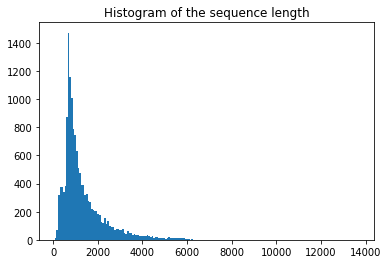

In [32]:
# plot the distribution of the length of the sequences
import matplotlib.pyplot as plt
_ = plt.hist(len_element, bins='auto')  
plt.title("Histogram of the sequence length")
plt.show()

Given the relatively large mean of the sequence length, choosing a max_length of 512 may not be appropriate and should be increased to 1024. This will increase the computation time, though.

*Is it an option to choose a relatively small max_length and still get good results?*

*Kick out outliers?*

In [33]:
# what do those really long sequences look like?
longest_sequences[1]


b"Titanic directed by James Cameron presents a fictional love story on the historical setting of the Titanic. The plot is simple, noncomplicated, or not for those who love plots that twist and turn and keep you in suspense. The end of the movie can be figured out within minutes of the start of the film, but the love story is an interesting one, however. Kate Winslett is wonderful as Rose, an aristocratic young lady betrothed by Cal (Billy Zane). Early on the voyage Rose meets Jack (Leonardo DiCaprio), a lower class artist on his way to America after winning his ticket aboard Titanic in a poker game. If he wants something, he goes and gets it unlike the upper class who are so concerned with their social worries. The two fall in love and the audience sees the sinking of the Titanic primarily through their eyes.<br /><br />The movie begins in modern times with the exploration of the wreck by a group searching for treasures, that sunk with the Titanic, which has recently occurred. One of t

This little exploration shows that the longest sequences are simply really long summaries of the plot coupled with a recommendation of whether or not to watch it. We should experiment with just taking the beginning of the sequence and the end, or even better: snip out parts in the middle since the beginning and the and are somewhat summaries of the sentiment.